# **MD/PhD Rejection Analyzer**

### Importing required packages

In [1]:
import re
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import math
import string
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px

### Functions required for analysis (run these first)

In [2]:
def text_parser(filepath):
    """
    Function for parsing through a .txt file of schools with users + dates.
    Provide a filepath for each .txt file
    """
    school_list = []
    file = open(filepath)
    for line in file:
        school_list.append(line)
    return(school_list)

In [3]:
def cycle_generator(text_list, cycle_start_year):
    """
    Function to select schools, users, complete & pre-secondary/pre-interview rejection dates.
    Make sure to clean and edit the txt files before running this - otherwise it throws errors with bad dates.
    Provide a text list from text_parser and the start year of the cycle.
    """
    schools = []
    first_users = []
    other_users = []
    completes_rejections = []
    
    # Finding the list of schools, the first and other usernames, and all the complete/interview dates in parentheses ().
    for school in text_list:
        try:
            s = re.findall(pattern="^(.*?):", string=school)
            for sc in s:
                schools.append(sc)
            
            user1 = re.findall(pattern=":(.*?)\(", string=school)[0]
            user1 = user1.replace(" ", "")
            first_users.append(user1)
            
            users = re.findall(pattern="\),(.*?)\(", string=school)
            users = [u.replace(" ", "") for u in users]
            other_users.append(users)
            
            cr = re.findall(pattern="\((.*?)\)", string=school)
            com_rej = []
            for x in cr:
                x = x.replace(" ", "")
                x = x.upper()
                com_rej.append(x)
            completes_rejections.append(com_rej)
        except:
            print("Typo in the following school:", school)
    
    # Combining the first and other users into one list
    all_users = []
    for f, o in zip(first_users, other_users):
        f = [f]
        total = f + o
        all_users.append(total)
    
    # Merging everything into a dataframe
    cr_df = pd.DataFrame({'schools': schools, 'users': all_users, 'rejection_dates': completes_rejections})
    
    # Exploding the dataframe on users and complete/rejection dates and merging to unlist the users and rejection dates
    cr_df_users = cr_df.loc[:, ['schools', 'users']].explode('users').reset_index(drop=True)
    cr_df_cr = cr_df.loc[:, ['schools', 'rejection_dates']].explode('rejection_dates').reset_index(drop=True)
    cr_df_users['rejection_dates'] = cr_df_cr['rejection_dates']
    cr_df_all = cr_df_users
    
    # Finding all the complete (C:) dates and rejection dates (R:).  Adding the years and converting to dates
    cs = []
    rs = []
    for cr in cr_df_all['rejection_dates']:
        try:
            c = re.findall(pattern="C:(.*?),", string=cr)[0]
            c_dates = c.split('/')
            if int(c_dates[0]) > 5:
                try:
                    c = c + "/" + str(cycle_start_year)
                    c = datetime.strptime(c, '%m/%d/%Y')
                except:
                    c = np.nan        
            if int(c_dates[0]) < 5:
                try:
                    c = c + "/" + str(cycle_start_year + 1)
                    c = datetime.strptime(c, '%m/%d/%Y')
                except:
                    c = np.nan
            cs.append(c)
            
            rej = re.findall(pattern="R:(.*)", string=cr)[0]
            rej_dates = rej.split('/')
            if int(rej_dates[0]) > 5:
                try:
                    rej = rej + "/" + str(cycle_start_year)
                    rej = datetime.strptime(rej, '%m/%d/%Y')
                except:
                    rej = np.nan        
            if int(rej_dates[0]) < 5:
                try:
                    rej = rej + "/" + str(cycle_start_year + 1)
                    rej = datetime.strptime(rej, '%m/%d/%Y')
                except:
                    rej = np.nan
            rs.append(rej)
        except:
            print("Typo in the following complete/rejection entry:", cr)
    
    # Making new columns for complete dates and rejection dates
    cr_df_all['complete'] = cs
    cr_df_all['rejection'] = rs
    
    # Calculating the wait time between complete date and rejection date
    cr_df_all['wait_time'] = (cr_df_all['rejection'] - cr_df_all['complete']).dt.days
    cr_df_all['cycle'] = str(cycle_start_year) + "-" + str(cycle_start_year + 1)
    
    # Returning the final df.  Comment out if giving an error
    return(cr_df_all)

In [4]:
def cycle_generator_post(text_list, cycle_start_year):
    """
    Function to select schools, users, complete & post-interview rejection dates.
    Make sure to clean and edit the txt files before running this - otherwise it throws errors with bad dates.
    Provide a text list from text_parser and the start year of the cycle.
    """
    schools = []
    first_users = []
    other_users = []
    interview_rejections = []
    
    # Finding the list of schools, the first and other usernames, and all the complete/interview dates in parentheses ().
    for school in text_list:
        try:
            s = re.findall(pattern="^(.*?):", string=school)
            for sc in s:
                schools.append(sc)
            
            user1 = re.findall(pattern=":(.*?)\(", string=school)[0]
            user1 = user1.replace(" ", "")
            first_users.append(user1)
            
            users = re.findall(pattern="\),(.*?)\(", string=school)
            users = [u.replace(" ", "") for u in users]
            other_users.append(users)
            
            ir = re.findall(pattern="\((.*?)\)", string=school)
            int_rej = []
            for x in ir:
                x = x.replace(" ", "")
                x = x.upper()
                int_rej.append(x)
            interview_rejections.append(int_rej)
        except:
            print("Typo in the following school:", school)
    
    # Combining the first and other users into one list
    all_users = []
    for f, o in zip(first_users, other_users):
        f = [f]
        total = f + o
        all_users.append(total)
    
    # Merging everything into a dataframe
    ir_df = pd.DataFrame({'schools': schools, 'users': all_users, 'rejection_dates': interview_rejections})
    
    # Exploding the dataframe on users and interview/rejection dates and merging to unlist the users and rejection dates
    ir_df_users = ir_df.loc[:, ['schools', 'users']].explode('users').reset_index(drop=True)
    ir_df_ir = ir_df.loc[:, ['schools', 'rejection_dates']].explode('rejection_dates').reset_index(drop=True)
    ir_df_users['rejection_dates'] = ir_df_ir['rejection_dates']
    ir_df_all = ir_df_users
    
    # Finding all the interview (I:) dates and rejection dates (R:).  Adding the years and converting to dates
    interviews = []
    rs = []
    for ir in ir_df_all['rejection_dates']:
        try:
            i = re.findall(pattern="I:(.*?),", string=ir)[0]
            i_dates = i.split('/')
            if int(i_dates[0]) > 6:
                try:
                    i = i + "/" + str(cycle_start_year)
                    i = datetime.strptime(i, '%m/%d/%Y')
                except:
                    i = np.nan        
            if int(i_dates[0]) < 6:
                try:
                    i = i + "/" + str(cycle_start_year + 1)
                    i = datetime.strptime(i, '%m/%d/%Y')
                except:
                    i = np.nan
            interviews.append(i)
            
            rej = re.findall(pattern="R:(.*)", string=ir)[0]
            rej_dates = rej.split('/')
            if int(rej_dates[0]) > 6:
                try:
                    rej = rej + "/" + str(cycle_start_year)
                    rej = datetime.strptime(rej, '%m/%d/%Y')
                except:
                    rej = np.nan        
            if int(rej_dates[0]) < 6:
                try:
                    rej = rej + "/" + str(cycle_start_year + 1)
                    rej = datetime.strptime(rej, '%m/%d/%Y')
                except:
                    rej = np.nan
            rs.append(rej)
        except:
            print("Typo in the following interview/rejection entry:", ir)
    
    # Making new columns for interview dates and rejection dates
    ir_df_all['interview'] = interviews
    ir_df_all['rejection'] = rs
    
    # Calculating the wait time between interview date and rejection date
    ir_df_all['wait_time'] = (ir_df_all['rejection'] - ir_df_all['interview']).dt.days
    ir_df_all['cycle'] = str(cycle_start_year) + "-" + str(cycle_start_year + 1)
    
    # Returning the final df.  Comment out if giving an error
    return(ir_df_all)

### Importing the .txt school list files

In [5]:
# Give a central directory were you downloaded everything.
directory = "C:/Users/TooFastDan/Documents/MD_PhD Application/Python Analysis/SDN rejections"

# Importing the .txt files for the pre-secondary rejections
#cycle_2021_ps = text_parser(filepath=directory + "/2021-2022 pre-secondary rejections.txt")
cycle_2020_ps = text_parser(filepath=directory + "/2020-2021 pre-secondary rejections.txt")
cycle_2019_ps = text_parser(filepath=directory + "/2019-2020 pre-secondary rejections.txt")
cycle_2018_ps = text_parser(filepath=directory + "/2018-2019 pre-secondary rejections.txt")

# Importing the .txt files for the pre-interview rejections
#cycle_2021_pre = text_parser(filepath=directory + "/2021-2022 pre-interview rejections.txt")
cycle_2020_pre = text_parser(filepath=directory + "/2020-2021 pre-interview rejections.txt")
cycle_2019_pre = text_parser(filepath=directory + "/2019-2020 pre-interview rejections.txt")
cycle_2018_pre = text_parser(filepath=directory + "/2018-2019 pre-interview rejections.txt")

# Importing the .txt files for the post-interview rejections
#cycle_2021_post = text_parser(filepath=directory + "/2021-2022 post-interview rejections.txt")
cycle_2020_post = text_parser(filepath=directory + "/2020-2021 post-interview rejections.txt")
cycle_2019_post = text_parser(filepath=directory + "/2019-2020 post-interview rejections.txt")
cycle_2018_post = text_parser(filepath=directory + "/2018-2019 post-interview rejections.txt")

### Making dataframes for each cycle's pre-secondary rejections using the cycle_generator() function

In [6]:
# Generating dataframes from the txt files.  If giving an error, comment out the return statement in the cycle_generator() function.
#presec_rs_2021 = cycle_generator(text_list=cycle_2021_ps, cycle_start_year=2021)
presec_rs_2020 = cycle_generator(text_list=cycle_2020_ps, cycle_start_year=2020)
presec_rs_2019 = cycle_generator(text_list=cycle_2019_ps, cycle_start_year=2019)
presec_rs_2018 = cycle_generator(text_list=cycle_2018_ps, cycle_start_year=2018)

print("2020-2021 cycle users:", len(presec_rs_2020), 
      "\n2019-2020 cycle users:", len(presec_rs_2019),
      "\n2018-2019 cycle users:", len(presec_rs_2018))

2020-2021 cycle users: 14 
2019-2020 cycle users: 6 
2018-2019 cycle users: 8


### Making dataframes for each cycle's pre-interview rejections using the cycle_generator() function

In [7]:
# Generating dataframes from the txt files.  If giving an error, comment out the return statement in the cycle_generator() function.
#preint_rs_2021 = cycle_generator(text_list=cycle_2021_pre, cycle_start_year=2021)
preint_rs_2020 = cycle_generator(text_list=cycle_2020_pre, cycle_start_year=2020)
preint_rs_2019 = cycle_generator(text_list=cycle_2019_pre, cycle_start_year=2019)
preint_rs_2018 = cycle_generator(text_list=cycle_2018_pre, cycle_start_year=2018)

print("2020-2021 cycle users:", len(preint_rs_2020), 
      "\n2019-2020 cycle users:", len(preint_rs_2019),
      "\n2018-2019 cycle users:", len(preint_rs_2018))

2020-2021 cycle users: 321 
2019-2020 cycle users: 133 
2018-2019 cycle users: 235


### Making dataframes for each cycle's post-interview rejections using the cycle_generator_post() function

In [8]:
# Generating dataframes from the txt files.  If giving an error, comment out the return statement in the cycle_generator() function.
#postint_rs_2021 = cycle_generator(text_list=cycle_2021_post, cycle_start_year=2021)
postint_rs_2020 = cycle_generator_post(text_list=cycle_2020_post, cycle_start_year=2020)
postint_rs_2019 = cycle_generator_post(text_list=cycle_2019_post, cycle_start_year=2019)
postint_rs_2018 = cycle_generator_post(text_list=cycle_2018_post, cycle_start_year=2018)

print("2020-2021 cycle users:", len(postint_rs_2020), 
      "\n2019-2020 cycle users:", len(postint_rs_2019),
      "\n2018-2019 cycle users:", len(postint_rs_2018))

2020-2021 cycle users: 17 
2019-2020 cycle users: 4 
2018-2019 cycle users: 26


## Cleaning the data some more and Exporting excel files

In [9]:
def cleaner(df, cycle, rejection_type, drop_nas):
    """
    Cleans rejection dfs for further processing.  
    Provide a df, a string of the start cycle, a string of the rejection type, and a T/F of whether or not to drop na rejection values.
    """
    df['cycle'] = cycle
    df['rejection_type'] = rejection_type
    if drop_nas is True:
        df = df[df.iloc[:, 4].notna()]
        df = df.sort_values(by="rejection").reset_index(drop=True)
        df['rank'] = [r+1 for r in range(len(df))]
        df['percent'] = (df['rank'] / len(df)) * 100
    if drop_nas is False:
        df = df.sort_values(by="rejection").reset_index(drop=True)
    return(df)

In [14]:
# Pre-secondary Cleaning
presec_rs_2020_c = cleaner(df=presec_rs_2020, cycle="2020-2021", rejection_type="pre-secondary", drop_nas=False)
presec_rs_2019_c = cleaner(df=presec_rs_2019, cycle="2019-2020", rejection_type="pre-secondary", drop_nas=False)
presec_rs_2018_c = cleaner(df=presec_rs_2018, cycle="2018-2019", rejection_type="pre-secondary", drop_nas=False)

# Pre-interview Cleaning
preint_rs_2020_c = cleaner(df=preint_rs_2020, cycle="2020-2021", rejection_type="pre-interview", drop_nas=False)
preint_rs_2019_c = cleaner(df=preint_rs_2019, cycle="2019-2020", rejection_type="pre-interview", drop_nas=False)
preint_rs_2018_c = cleaner(df=preint_rs_2018, cycle="2018-2019", rejection_type="pre-interview", drop_nas=False)

# Post-interview Cleaning
postint_rs_2020_c = cleaner(df=postint_rs_2020, cycle="2020-2021", rejection_type="post-interview", drop_nas=False)
postint_rs_2019_c = cleaner(df=postint_rs_2019, cycle="2019-2020", rejection_type="post-interview", drop_nas=False)
postint_rs_2018_c = cleaner(df=postint_rs_2018, cycle="2018-2019", rejection_type="post-interview", drop_nas=False)

In [24]:
# Concatenating all rejections list into one single df
rej_all = pd.concat([presec_rs_2020_c, presec_rs_2019_c, presec_rs_2018_c, 
                    preint_rs_2020_c, preint_rs_2019_c, preint_rs_2018_c,
                    postint_rs_2020_c, postint_rs_2019_c, postint_rs_2018_c],
                    axis=0, ignore_index=True)
rej_all = rej_all[["schools", "users", "rejection_dates", "complete", "interview", "rejection", "wait_time", "cycle", "rejection_type"]]
rej_all = rej_all.sort_values(["cycle", "rejection_type", "rejection"]).reset_index(drop=True)
rej_all.to_excel(directory+"/all_rejections_processed.xlsx", index=False)
rej_all

,schools,users,rejection_dates,complete,interview,rejection,wait_time,cycle,rejection_type
0,Medical University of South Carolina,Thoroughbred_med,"I:10/26,R:11/30",NaT,2018-10-26,2018-11-30,35.0,2018-2019,post-interview
1,University of Iowa,PursuingHappy,"I:10/X,R:12/4",NaT,NaT,2018-12-04,NaN,2018-2019,post-interview
2,University of Nebraska Medical Center,Thoroughbred_med,"I:10/10,R:12/14",NaT,2018-10-10,2018-12-14,65.0,2018-2019,post-interview
3,University of Iowa,44sigma,"I:12/9,R:1/9",NaT,2018-12-09,2019-01-09,31.0,2018-2019,post-interview
4,Drexel,Thoroughbred_med,"I:10/16,R:1/14",NaT,2018-10-16,2019-01-14,90.0,2018-2019,post-interview
...,...,...,...,...,...,...,...,...,...
759,University of Washington,ac_505,"C:8/24,R:9/6",2020-08-24,NaT,2020-09-06,13.0,2020-2021,pre-secondary
760,University of Washington,wrhen,"C:9/X,R:9/22",NaT,NaT,2020-09-22,NaN,2020-2021,pre-secondary
761,University of Iowa,neurozf5,"C:8/3,R:9/22",2020-08-03,NaT,2020-09-22,50.0,2020-2021,pre-secondary
762,Emory University,neurozf5,"C:8/3,R:9/25",2020-08-03,NaT,2020-09-25,53.0,2020-2021,pre-secondary


In [88]:
# Redoing the cycle column
ii_2021['cycle'] = '2021-2022 *Incomplete'
ii_2020['cycle'] = '2020-2021'
ii_2019['cycle'] = '2019-2020'
ii_2018['cycle'] = '2018-2019'

# Dropping na values for interviews (optional - nice if you want to graph things, but not if you want a complete dataset)
ii_2021 = ii_2021[ii_2021['II_date'].notna()]
ii_2020 = ii_2020[ii_2020['II_date'].notna()]
ii_2019 = ii_2019[ii_2019['II_date'].notna()]
ii_2018 = ii_2018[ii_2018['II_date'].notna()]

# Sorting by interview invite date
ii_2021 = ii_2021.sort_values(by="II_date")
ii_2020 = ii_2020.sort_values(by="II_date")
ii_2019 = ii_2019.sort_values(by="II_date")
ii_2018 = ii_2018.sort_values(by="II_date")

# Numbering every II
ii_2021['rank'] = [i+1 for i in range(len(ii_2021))]
ii_2020['rank'] = [i+1 for i in range(len(ii_2020))]
ii_2019['rank'] = [i+1 for i in range(len(ii_2019))]
ii_2018['rank'] = [i+1 for i in range(len(ii_2018))]

# Creating a percent for suvival analysis
ii_2021['percent'] = (ii_2021['rank'] / 370) * 100  #assuming there are 370 final entries
ii_2020['percent'] = (ii_2020['rank'] / len(ii_2020)) * 100
ii_2019['percent'] = (ii_2019['rank'] / len(ii_2019)) * 100
ii_2018['percent'] = (ii_2018['rank'] / len(ii_2018)) * 100

# Concatenating all application cycles into one df
ii_all = pd.concat([ii_2021, ii_2020, ii_2019, ii_2018], axis=0, ignore_index=True)

In [20]:
# Deidentifying everyone, sorting, and exporting to xlsx

#ii_all_de = ii_all.drop(["users", "rank", "percent"], axis=1)
#ii_all_de["cycle"] = pd.Categorical(ii_all_de["cycle"], ["2021-2022 *Incomplete", "2020-2021", "2019-2020", "2018-2019"])
#ii_all_de = ii_all_de.sort_values(by=["cycle", "schools"])
#ii_all_de.to_excel(directory+"/all_iis_deidentified.xlsx", index=False)

In [75]:
# Viewing the dataframe, exporting to xlsx, and counting the entries in each file

display(ii_all)
#ii_all.to_excel(directory+"/all_iis_processed.xlsx", index=False)

print("2021-2022 cycle users:", len(ii_2021),
      "\n2020-2021 cycle users:", len(ii_2020), 
      "\n2019-2020 cycle users:", len(ii_2019),
      "\n2018-2019 cycle users:", len(ii_2018))

,schools,users,complete_interview,complete_date,II_date,wait_time,cycle,rank,percent
0,UT San Antonio,DrDriven07,"C:7/10,II:7/30",2021-07-10,2021-07-30,20.0,2021-2022 *Incomplete,1,0.270270
1,Texas A&M,VaultArmitage,"C:7/19,II:7/30",2021-07-19,2021-07-30,11.0,2021-2022 *Incomplete,2,0.540541
2,UT San Antonio,baz2020,"C:7/10,II:7/30",2021-07-10,2021-07-30,20.0,2021-2022 *Incomplete,3,0.810811
3,UT San Antonio,NeuroImmunoMSTP,"C:7/10,II:7/30",2021-07-10,2021-07-30,20.0,2021-2022 *Incomplete,4,1.081081
4,UT San Antonio,lucyaxolotl,"C:7/10,II:7/30",2021-07-10,2021-07-30,20.0,2021-2022 *Incomplete,5,1.351351
...,...,...,...,...,...,...,...,...,...
1319,University of Miami,Thoroughbred_med,"C:8/5,II:1/21",2021-08-05,2022-01-21,169.0,2018-2019,390,98.984772
1320,UC Irvine,cavesnakess,"C:9/9,II:1/22",2021-09-09,2022-01-22,135.0,2018-2019,391,99.238579
1321,University of Miami,peanutbuttercup24,"C:8/13,II:1/23",2021-08-13,2022-01-23,163.0,2018-2019,392,99.492386
1322,Case Western,cavesnakess,"C:8/26,II:2/10",2021-08-26,2022-02-10,168.0,2018-2019,393,99.746193


2021-2022 cycle users: 226 
2020-2021 cycle users: 362 
2019-2020 cycle users: 342 
2018-2019 cycle users: 394


# **Figures**

## Kaplan-Meier Suvival Curves

<ipython-input-40-bd2113c120d9>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


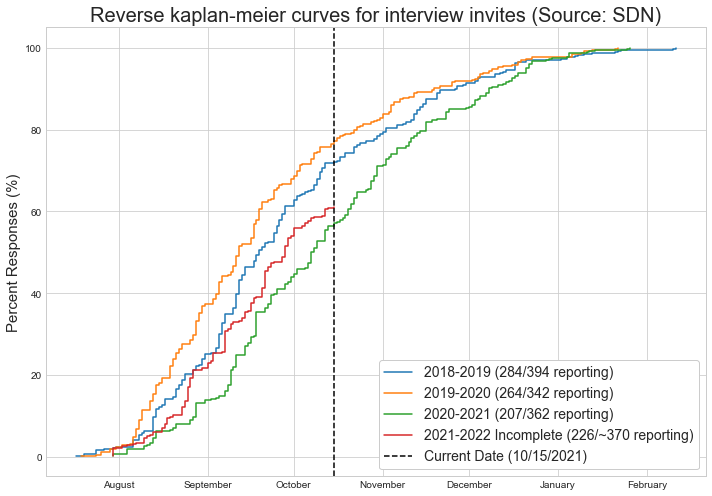

In [40]:
%matplotlib inline

# Style and figure size
plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(figsize=(10, 7))

# Plotting one line for each cycle.  Important to set the same year for overlay
ax.step(x=ii_2018['II_date'], y=ii_2018['percent'], label="2018-2019 (284/394 reporting)", where="post")
ax.step(x=ii_2019['II_date'], y=ii_2019['percent'], label="2019-2020 (264/342 reporting)", where="post")
ax.step(x=ii_2020['II_date'], y=ii_2020['percent'], label="2020-2021 (207/362 reporting)", where="post")
ax.step(x=ii_2021['II_date'], y=ii_2021['percent'], label="2021-2022 Incomplete (226/~370 reporting)", where="post")

# Plotting vertical line for the current date
plt.axvline(x=datetime.strptime("10/15/2021", '%m/%d/%Y'), color="#000000", ls="--", lw=1.5, label='Current Date (10/15/2021)')

# Tick, axis, and title labels
#plt.xlabel("Date")
tick_labels = ['August', 'September', 'October', 'November', 'December', 'January', 'February']
ax.set_xticklabels(tick_labels)
ax.set_ylabel("Percent Responses (%)", fontsize=15)
ax.set_title("Reverse kaplan-meier curves for interview invites (Source: SDN)", fontsize=20)
ax.legend(fontsize=14, loc='lower right', facecolor='white', framealpha=1, frameon=True)

# Displaying the figure
plt.tight_layout()

# Saving the figure
#plt.savefig(directory+"/kaplan-meier iis.png", dpi=300)

## Population Density Curves

<ipython-input-63-64d302179b1d>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(tick_labels)


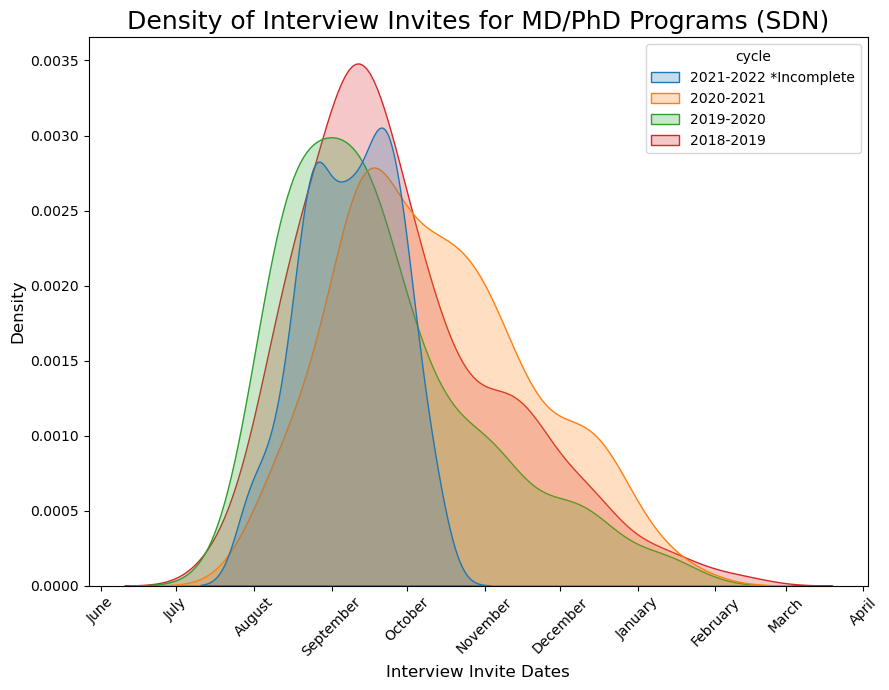

In [63]:
%matplotlib inline

# Setting the style and figure size
#sns.set_style("ticks")
plt.style.use("default")
plt.figure(figsize=(9, 7))

# Density Plot
plot = sns.kdeplot(data=ii_all, x="II_date", hue='cycle', fill=True)

# Tick, axis, and title labels
plt.xticks(rotation=45)
plot.set_xlabel("Interview Invite Dates", fontsize=12)
tick_labels = ["June", "July", "August", "September", "October", "November", "December", "January", "February", "March", "April"]
plot.set_xticklabels(tick_labels)
plot.set_ylabel("Density", fontsize=12)
plot.set_title("Density of Interview Invites for MD/PhD Programs (SDN)", fontsize=18)

# Displaying the figure
plt.tight_layout()

# Saving the figure
#plt.savefig(directory+"/ii_kde.png", dpi=300)

## Plotting a bargraph of waittimes between secondary completion and interview invite

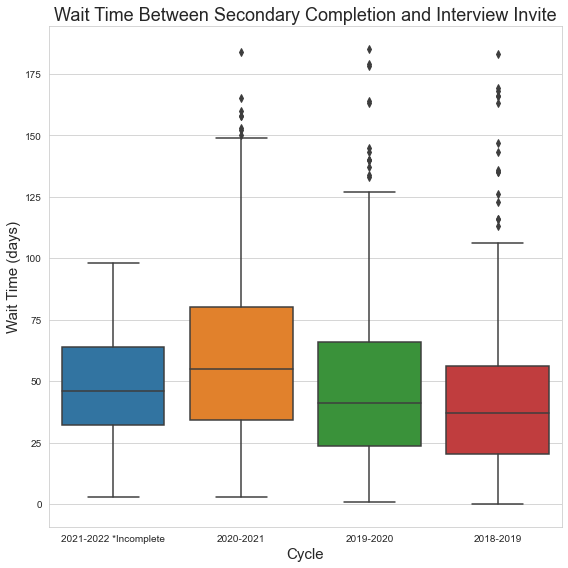

In [43]:
%matplotlib inline

# Figure style and size 
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))

# Boxplot of wait time
sns.boxplot(data=ii_all, x="cycle", y="wait_time")

# Axix and title labels
plt.xlabel("Cycle", fontsize=15)
plt.ylabel("Wait Time (days)", fontsize=15)
plt.title("Wait Time Between Secondary Completion and Interview Invite", fontsize=18)

# Displaying the figure
plt.tight_layout()

# Saving the figure
#plt.savefig(directory+"/wait time boxplot.jpg", dpi=300)

## Making a huge graph for all individual interview invites per school (takes a long time to process)

<ipython-input-61-dd25bacfca14>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(['August', 'September', 'October', 'November', 'December', 'January', 'February'])


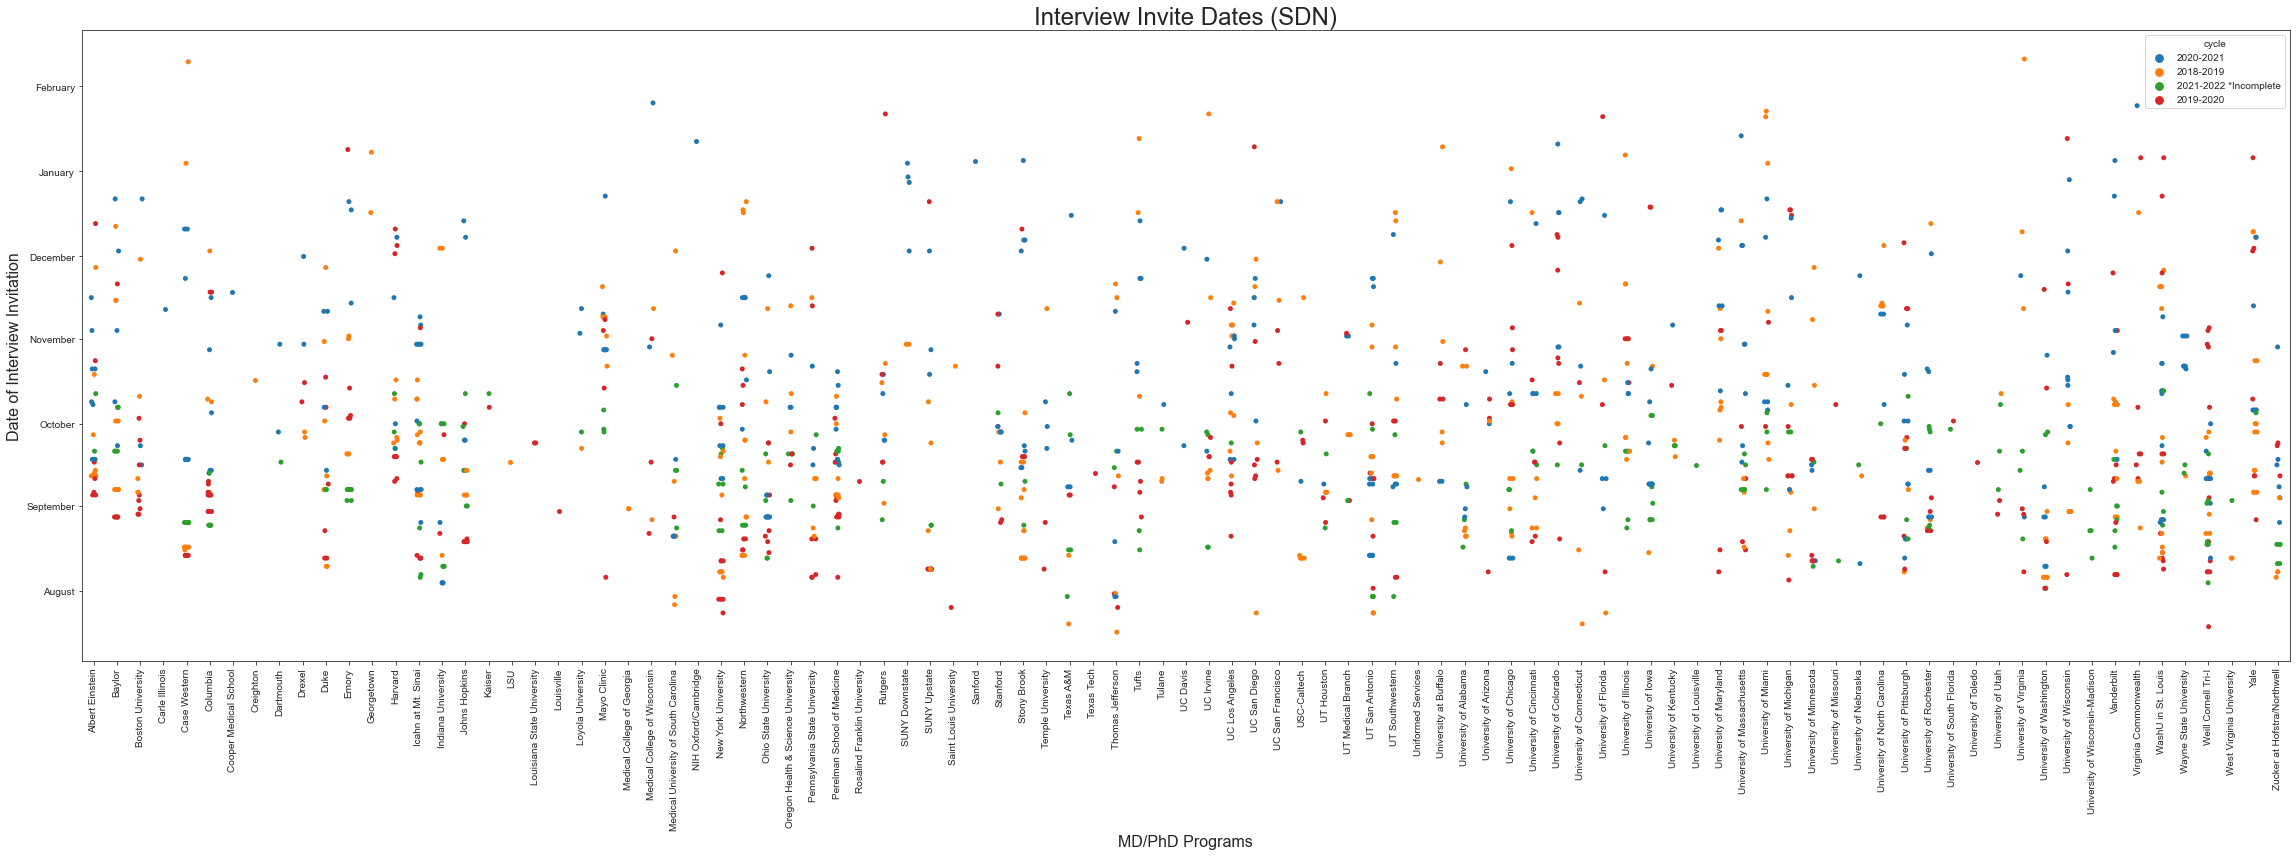

In [61]:
%matplotlib inline

# Setting the figure style and size (big figure)
sns.set_style("ticks")
plt.figure(figsize=(32, 12))

# Extra processing - alphabetical sorting and categorical datatypes to make figures cleaner
ii_all2 = ii_all.sort_values("schools")
school_order = CategoricalDtype(ii_all2["schools"].unique(), ordered=True)
ii_all2['schools'] = ii_all2["schools"].astype(school_order)
ii_all2 = ii_all2.sort_values("schools")

# Plotting a stripplot for each interview invite date, colored by cycle
plot = sns.stripplot(data=ii_all2, x='schools', y='II_date', hue='cycle')

# Tick, axis, and title labels
plt.xticks(rotation=90)
plot.set_xlabel("MD/PhD Programs", fontsize=16)
plot.set_ylabel("Date of Interview Invitation", fontsize=16)
plot.set_yticklabels(['August', 'September', 'October', 'November', 'December', 'January', 'February'])
plot.set_title("Interview Invite Dates (SDN)", fontsize=24)

# Displaying the figure
plt.tight_layout()

# Saving the figure
#plt.savefig(directory+"/all_iis.png", dpi=300)

## Making a plot of the wait time between secondary completion and interview invite per program (takes a long time to process)

In [84]:
### Preprocssing to exclude small schools and calulate interquartile range ###

# Excluding schools with not a lot of data (they clutter things up)
exclude = ['Creighton', 'Georgetown', 'Loyola University', 'LSUHSC', 'Medical College of Georgia',
           'Saint Louis University', 'Tulane', 'Uniformed Services', 'University of Kentucky',
           'University of Nebraska', 'University of Utah', 'Wayne State University',
           'West Virginia University', 'Kaiser', 'Louisiana State University', 
           'Rosalind Franklin University', 'Texas Tech', 'UC Davis', 'University of Missouri', 
           'University of South Florida', 'University of Toledo', 'Carle Illinois',
           'Cooper Medical School', 'Dartmouth', 'NIH Oxford/Cambridge', 'Sanford', 
           'University of Louisville', 'LSU', 'Louisville']
ii_all3 = ii_all[~ii_all['schools'].isin(exclude)]
ii_all3 = ii_all3[ii_all3['wait_time'].notna()]  # dropping na values from wait_time

# Calculating the interquartile range for each school
Q1 = ii_all3.groupby('schools').quantile(0.25)
Q3 = ii_all3.groupby('schools').quantile(0.75)
IQR = Q3['wait_time'] - Q1['wait_time']
IQR = pd.DataFrame(IQR).sort_values(by='wait_time')

# Sorting the main ii_all3 dataframe by mapping lowest to highest interquartile range
ordered = CategoricalDtype(IQR.index, ordered=True)
ii_all3['schools'] = ii_all3['schools'].astype(ordered)
ii_all3 = ii_all3.sort_values(by='schools')
#ii_all3

C:\Users\TooFastDan\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 14.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


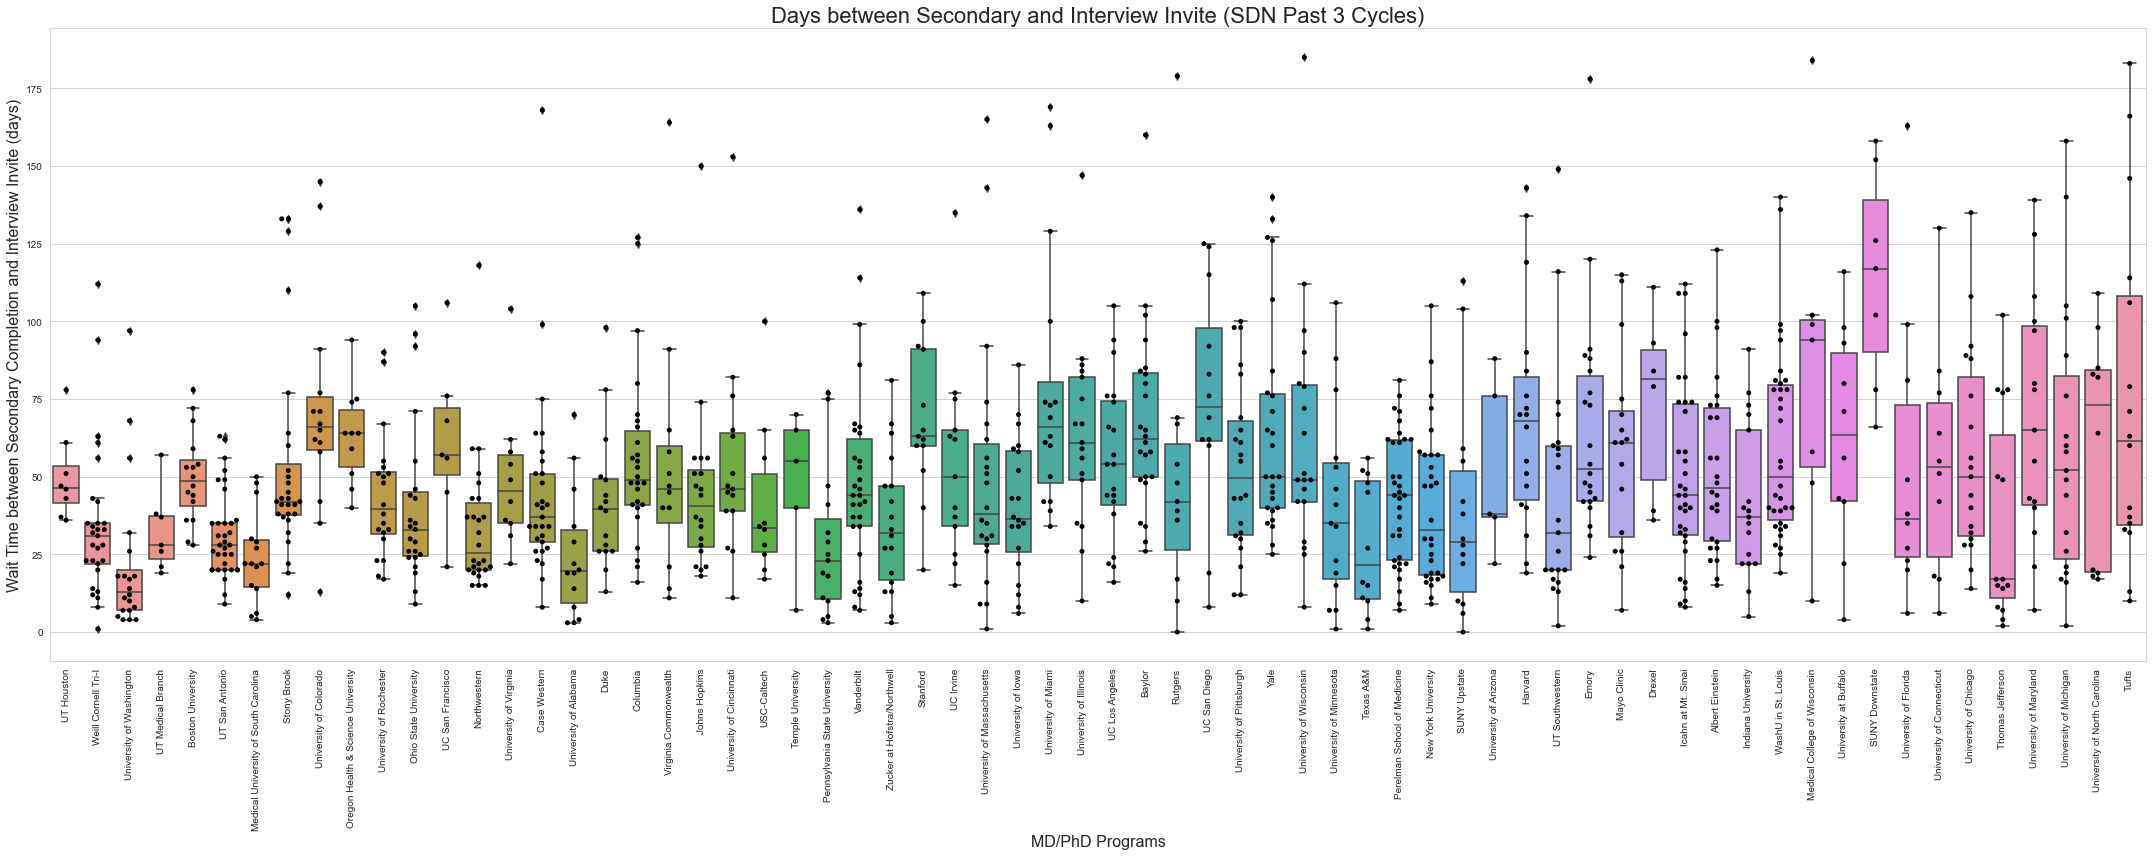

In [85]:
%matplotlib inline

# Setting the style and figure size
sns.set_style("whitegrid")
plt.figure(figsize=(30, 12))

# Making a boxplot of the wait time overlayed by individual points (swarmplot)
plot = sns.boxplot(data=ii_all3, x='schools', y='wait_time')
plot = sns.swarmplot(data=ii_all3, x='schools', y='wait_time', color='black')

# Tick, axis, and title labels
plt.xticks(rotation=90)
plot.set_xlabel("MD/PhD Programs", fontsize=16)
plot.set_ylabel("Wait Time between Secondary Completion and Interview Invite (days)", fontsize=16)
plot.set_title("Days between Secondary and Interview Invite (SDN Past 3 Cycles)", fontsize=22)

# Displaying the figure
plt.tight_layout()

# Saving the figure
#plt.savefig(directory+'/ii_timelapse_IQR_Sorted.png', dpi=300)

## Making a plot of the most common days of the week to be sent interview invites

In [90]:
# Translating between dates and days of the week

# 0 = monday, 1 = tueday, 2 = wednesday, 3 = thursday, 4 = friday, 5 = saturday, 6 = sunday
ii_2021["weekdays"] = [ii.weekday() for ii in ii_2021["II_date"]]
ii_2021["weekdays"].replace({0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}, inplace=True)
days_df = pd.DataFrame(ii_2021["weekdays"].value_counts().reset_index())
days_df.columns = ["Week_Day", "Count"]

# Sorting according to weekday
days_df["Week_Day"] = pd.Categorical(days_df["Week_Day"], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
days_df.sort_values("Week_Day", inplace=True)
days_df

,Week_Day,Count
3,Monday,33
0,Tuesday,72
2,Wednesday,41
4,Thursday,31
1,Friday,46
5,Saturday,2
6,Sunday,1


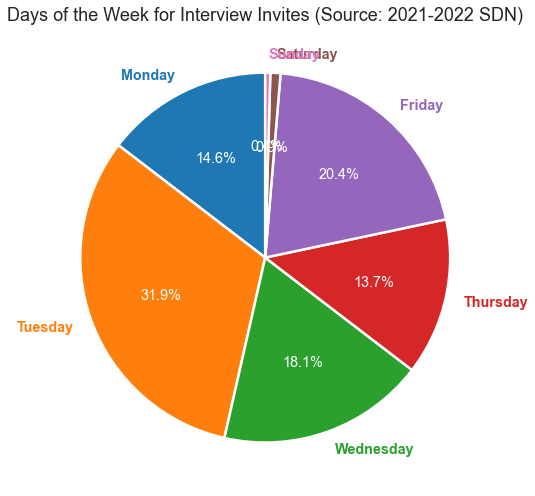

In [93]:
%matplotlib inline

# Setting the figure style and size
fig, ax = plt.subplots(figsize=(9, 7))

# Plotting the pie chart with some custom colors and functions
patches, texts, pcts = ax.pie(x=days_df['Count'], labels=days_df['Week_Day'], autopct='%.1f%%',
    wedgeprops={'linewidth': 2.5, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    startangle=90)
#for each wedge, set the corresponding text label color to the wedge's face color
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)

# Labelling the title
ax.set_title("Days of the Week for Interview Invites (Source: 2021-2022 SDN)", fontsize=18)

# Displaying the figure
plt.tight_layout()

# Saving the figure
#plt.savefig(directory+"/weekdays pie charts.jpg", dpi=300)

## Plotting Complete Date vs Wait Time for each cycle (incomplete)

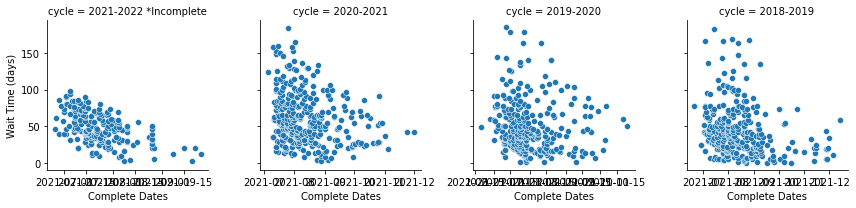

In [42]:
%matplotlib inline

# Figure style and size
#sns.set(rc={'figure.figsize':(12, 8)})

# Dotplot facetgrid for each cycle and wait time
grid = sns.FacetGrid(ii_all, col="cycle", sharex=False)
grid.map(sns.scatterplot, "complete_date", "wait_time")
grid.set_axis_labels(x_var="Complete Dates", y_var="Wait Time (days)")

# Displaying the figure
plt.tight_layout()

# **Generating Summary Statistics**

In [18]:
def summary_stats(df):
    """
    Creating some summary statistics and making dataframes to export.
    Returns 3 dataframes.
    """
    total_iis = len(df)
    total_programs = len(pd.unique(df['schools']))
    sdn_users = len(pd.unique(df['users']))
    summary_stats = [total_iis, total_programs, sdn_users]
    rownames = ["Total number of interview invites reported on SDN", 
                "Number of programs reporting interviews on SDN",
                "Number of unique users on SDN"]
    summary_df = pd.DataFrame(summary_stats, index=rownames, columns=["Number Reporting"])
    school_iis = pd.DataFrame({"II's per school on SDN": df['schools'].value_counts()})
    user_iis = pd.DataFrame({"II's per SDN user": df['users'].value_counts()})
    return(summary_df, school_iis, user_iis)

In [19]:
# Calling the summary_stats() function - better if used with no NA values are dropped 

summary_df, school_iis, user_iis = summary_stats(df=ii_2021)
display(summary_df)
display(school_iis)
display(user_iis)

,Number Reporting
Total number of interview invites reported on SDN,236
Number of programs reporting interviews on SDN,69
Number of unique users on SDN,47


,II's per school on SDN
Emory,10
Icahn School of Medicine at Mount Sinai,8
UT San Antonio,8
Weill Cornell/Rockefeller/Sloan Kettering - Tri-I,7
University of Iowa,7
...,...
University of Connecticut,1
Virginia Commonwealth University,1
University of North Carolina,1
University of Louisville,1


,II's per SDN user
DrDriven07,17
mdphd63627,15
MacroPhagoCytosis,14
toolcake,11
TheCicadaCircle,10
MDPhDcapable,9
NeuroImmunoMSTP,9
yibs,9
humoralhuman,9
larynxlady,9


In [21]:
### Writing to a multi-sheet excel doc with the summary statistics ###
writer = pd.ExcelWriter(directory+'/2021-2022 summary stats.xlsx', engine='xlsxwriter')

summary_df.to_excel(writer, sheet_name="Summary_Stats")
school_iis.to_excel(writer, sheet_name="IIs_per_program")
user_iis.to_excel(writer, sheet_name="IIs_per_SDNuser")
ii_2021.to_excel(writer, sheet_name="cycle_processed", index=False)

writer.save()
writer.close()

C:\Users\TooFastDan\anaconda3\lib\site-packages\xlsxwriter\workbook.py:336: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [20]:
# Checking the number of schools, number of IIs per school, number of users, and number of IIs per user 
print("Total number of interview invites reported on SDN:", len(ii_2021))
print("\n")
print("Number of programs reporting interviews on SDN:", len(pd.unique(ii_2021['schools'])))
print("\n")
print("Number of individual users on SDN:", len(pd.unique(ii_2021['users'])))
print("\n")
print("Number of interview invites per program:\n", 
      pd.DataFrame({"ii_number": ii_2021['schools'].value_counts()}))
print("\n")
print("Number of interviews per user on SDN:\n",
      pd.DataFrame({"ii_per_user": ii_2021['users'].value_counts()}))

Total number of interview invites reported on SDN: 236


Number of programs reporting interviews on SDN: 69


Number of individual users on SDN: 47


Number of interview invites per program:
                                                    ii_number
Emory                                                     10
Icahn School of Medicine at Mount Sinai                    8
UT San Antonio                                             8
Weill Cornell/Rockefeller/Sloan Kettering - Tri-I          7
University of Iowa                                         7
...                                                      ...
University of Connecticut                                  1
Virginia Commonwealth University                           1
University of North Carolina                               1
University of Louisville                                   1
Rutgers New Jersey Medical School                          1

[69 rows x 1 columns]


Number of interviews per user on SDN:
             

In [120]:
?plt.axvline

In [65]:
?plt.step

In [125]:
?plt.savefig